In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import glob
import librosa
import numpy as np
import librosa.display
import moviepy.editor as mp
import csv
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale
from Audio_Sentiment_Analysis.utils.Configuration import Configuration

In [2]:
AUDIO_DIR = f"{os.path.abspath('./../../')}/eNTERFACE05_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"
config = Configuration.load_json(CONFIG_FILE)

In [3]:
def extract_features(audio_file, subject, emotion, analysis=False):
    file = audio_file.split(".")[-2].split("\\")[-1]

    y, sr = librosa.load(audio_file, res_type='kaiser_fast')

    mfcc = librosa.feature.mfcc(y, sr=sr)
    mel_spect = librosa.feature.melspectrogram(y, sr=sr, n_mels=config.n_mels)
    rms = librosa.feature.rms(y)
    chroma_stft = librosa.feature.chroma_stft(y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y, sr=sr)
    spec_cont = librosa.feature.spectral_contrast(y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y, sr=sr)
    spec_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    if analysis:
        return [file, subject, emotion, y, sr, mel_spect, mfcc, chroma_stft, rms, spec_cent,\
            spec_cont, spec_bw, spec_rolloff, zcr]

    features_str = f'{file} {subject} {emotion} {np.mean(mel_spect)} {np.min(mel_spect)} {np.max(mel_spect)} {np.var(mel_spect)} {np.std(mel_spect)}\
        {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_cont)} {np.mean(spec_bw)} {np.mean(spec_rolloff)} {np.mean(zcr)}'

    for e in mfcc:
        features_str += f' {np.mean(e)}'

    return features_str.split()

In [4]:
def process_data(audio_dir, proc_feat_dataset):
    # Create a CSV for storing all processed features and write the header
    header = 'File Subject Emotion mel_mean mel_min mel_max mel_var mel_std chroma_stft rms spectral_centroid spectral_contrast spectral_bandwidth spectral_rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(header)

    print("Processing audio files from all subjects:")
    for file_path in tqdm(glob.glob(audio_dir+'/*/*/*/*.avi')):
        labels =  file_path.split('\\')
        # labels =  file_path.split('/')
        subject = labels[-4].split()[1]
        emotion = labels[-3]

        audio_file_path = file_path[:-3] + 'wav'
        # convert file type to wav
        if not os.path.isfile(audio_file_path):
            audio_clip = mp.VideoFileClip(file_path)
            audio_clip.audio.write_audiofile(audio_file_path)
        file_path = audio_file_path

        processed_data = extract_features(file_path, subject, emotion)
        writer.writerow(processed_data)

In [5]:
process_data(AUDIO_DIR, EXTRACTED_FEATURES_FILE)

Processing audio files from all subjects:


100%|██████████| 1287/1287 [01:07<00:00, 18.96it/s]


In [6]:
columns = ['File', 'Subject', 'Emotion', 'signal', 'sample_rate', 'mel_spec', 'mfcc', 'chroma_stft', 'rms', 'spec_cent', 'spec_cont', 'spec_bw', 'spec_rolloff', 'zcr']
df = pd.DataFrame(columns=columns)

# Taking only one file per emotion for analysis purposes
for file_path in glob.glob(AUDIO_DIR+"/subject 1/*/sentence 1/*.wav"):
    labels =  file_path.split('\\')
    # labels =  file_path.split('/')
    subject = int(labels[-4].split()[1])
    emotion = labels[-3]

    features = extract_features(file_path, subject, emotion, analysis=True)

    df = df.append(pd.DataFrame(features, index=columns).transpose(), ignore_index=True)

df = df.sort_values(['Subject', 'Emotion'], ascending = (True, True))
df = df.set_index('Subject')
df

,File,Emotion,signal,sample_rate,mel_spec,mfcc,chroma_stft,rms,spec_cent,spec_cont,spec_bw,spec_rolloff,zcr
Subject,,,,,,,,,,,,,
1,s1_an_1,anger,"[0.00035997134, -0.0010580126, -0.002465626, -...",22050,"[[0.002001118, 0.0017819229, 0.0017195621, 0.0...","[[-429.37125, -428.35626, -430.707, -424.46725...","[[0.5232388, 0.95512575, 0.65299016, 0.5713822...","[[0.00292947, 0.0027857684, 0.002886968, 0.002...","[[2384.27082998268, 2214.5540898306135, 2182.2...","[[25.799500683313457, 11.802808267515715, 17.1...","[[2508.8527015113987, 2445.376495373341, 2444....","[[5749.365234375, 5717.0654296875, 5695.532226...","[[0.05859375, 0.08935546875, 0.11572265625, 0...."
1,s1_di_1,disgust,"[-0.0025622563, -0.0034742374, -0.00339574, -0...",22050,"[[0.00061486254, 0.00031024398, 0.0005338352, ...","[[-442.08148, -438.0669, -432.90442, -431.6646...","[[0.84143186, 0.44482687, 0.24220592, 0.239359...","[[0.004319746, 0.0045665894, 0.004676521, 0.00...","[[1720.3124112880482, 1840.9274810437814, 1858...","[[15.864219347069222, 21.242033830313293, 18.4...","[[2340.1718275240178, 2369.9048772245947, 2357...","[[4812.6708984375, 5189.501953125, 5232.568359...","[[0.01806640625, 0.029296875, 0.03515625, 0.04..."
1,s1_fe_1,fear,"[-0.0005461195, -0.001375034, -0.0018291043, -...",22050,"[[0.00077908766, 0.0005726051, 0.00046864187, ...","[[-449.71625, -437.88364, -437.4251, -436.3283...","[[0.31569567, 0.290736, 0.40799242, 0.4027527,...","[[0.0020123464, 0.0019575201, 0.0021035518, 0....","[[2509.8600573821905, 2305.1481896876003, 2303...","[[20.212726749047164, 16.257419325327792, 15.4...","[[2483.4336798415425, 2410.5307718770127, 2373...","[[5781.6650390625, 5706.298828125, 5706.298828...","[[0.08056640625, 0.11572265625, 0.1455078125, ..."
1,s1_ha_1,happiness,"[0.005203576, 0.00692266, 0.0043164613, 0.0037...",22050,"[[0.05813717, 0.015589418, 0.00064850575, 0.00...","[[-400.10773, -401.39014, -407.40433, -407.352...","[[0.2136221, 0.48645547, 0.5705706, 0.5136353,...","[[0.0106535815, 0.010839848, 0.010321966, 0.00...","[[1071.0337665235309, 1170.0913560351528, 1304...","[[11.511046337041286, 15.619945163582486, 20.9...","[[1901.0041792265936, 1911.6203911947607, 1918...","[[2056.4208984375, 2508.6181640625, 3057.71484...","[[0.01220703125, 0.01904296875, 0.02685546875,..."
1,s1_sa_1,sadness,"[0.002528819, 0.0033527634, 0.00316357, 0.0035...",22050,"[[0.0002053016, 0.00040284405, 0.00055165763, ...","[[-461.70282, -455.24207, -454.9842, -453.6672...","[[0.7226741, 0.4513452, 0.38463557, 0.71059716...","[[0.0019815986, 0.0019741307, 0.001966436, 0.0...","[[2559.415021752746, 2415.651750142723, 2242.1...","[[17.519788969109268, 16.191131753964005, 14.2...","[[2540.660677022586, 2481.381615843638, 2452.1...","[[5835.498046875, 5792.431640625, 5727.8320312...","[[0.064453125, 0.099609375, 0.13818359375, 0.1..."
1,s1_su_1,surprise,"[-0.002478476, -0.0022489727, -0.0009931215, -...",22050,"[[0.0070406534, 0.0018928761, 0.0005218058, 0....","[[-444.51828, -435.06427, -433.40033, -438.601...","[[0.9533648, 1.0, 0.6591135, 0.61946607, 0.522...","[[0.002375449, 0.0023385233, 0.0024376353, 0.0...","[[2364.3905920915613, 2304.316156381267, 2163....","[[13.81646846305432, 10.303392651002653, 21.10...","[[2518.4044792801024, 2417.9190041768666, 2354...","[[5781.6650390625, 5706.298828125, 5566.333007...","[[0.0595703125, 0.07861328125, 0.10791015625, ..."


In [7]:
def signal_analysis(signal, sample_rate):
    plt.figure(figsize=(14,3))

    print(f'Sample rate = {sample_rate}')
    print(f'Signal mean = {np.mean(abs(signal)):.5f}')
    print(f'Signal minimum = {np.std(signal):.5f}')
    print(f'Signal maximum = {np.std(signal):.5f}')
    print(f'Signal standard deviation = {np.std(signal):.5f}')
    print(f'Signal variance = {np.std(signal):.5f}')

    librosa.display.waveplot(signal, sr=sample_rate, max_sr=1000, alpha=0.25, color='r')
    plt.show()

In [17]:
def mel_spec_analysis(mel_spec):
    plt.figure(figsize=(14,3))

    print(f'Mel-Spectogram mean = {np.mean(abs(mel_spec)):.5f}')
    print(f'Mel-Spectogram minimum = {np.std(mel_spec):.5f}')
    print(f'Mel-Spectogram maximum = {np.std(mel_spec):.5f}')
    print(f'Mel-Spectogram standard deviation = {np.std(mel_spec):.5f}')
    print(f'Mel-Spectogram variance = {np.std(mel_spec):.5f}')

    librosa.display.specshow(mel_spec)
    plt.colorbar()
    plt.show()

In [15]:
def chromogram_analysis(chromogram):
    plt.figure(figsize=(14,3))

    print(f'Chromogram mean = {np.mean(abs(chromogram)):.5f}')
    print(f'Chromogram minimum = {np.std(chromogram):.5f}')
    print(f'Chromogram maximum = {np.std(chromogram):.5f}')
    print(f'Chromogram standard deviation = {np.std(chromogram):.5f}')
    print(f'Chromogram variance = {np.std(chromogram):.5f}')

    librosa.display.specshow(chromogram)
    plt.colorbar()
    plt.show()

In [10]:
def spec_cent_analysis(spec_cent, spec_rolloff, signal, sr):
    spectral_centroids = minmax_scale(np.concatenate(spec_cent))
    print(f'Spectral Centroids mean = {np.mean(spectral_centroids):.5f}')

    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    spectral_rolloff = minmax_scale(np.concatenate(spec_rolloff), config.scale_range)
    print(f'Spectral Rolloff mean = {np.mean(spectral_rolloff):.5f}')
    
    plt.figure(figsize=(14, 5))

    librosa.display.waveplot(signal, sr=sr, alpha=0.25)

    plt.plot(t, spectral_centroids, color='b', label="Spectral Centroids")

    plt.plot(t, spectral_rolloff, color='r', label="Spectral Rolloff")
    plt.legend()
    plt.show()

In [11]:
def rmse_analysis(rmse):
    rmse = minmax_scale(np.concatenate(rmse), config.scale_range)
    print(f'RMSE mean = {np.mean(rmse):.5f}')

    plt.figure(figsize=(14,5))
    plt.plot(rmse)
    plt.ylabel('RMSE')
    plt.show()

In [12]:
def zcr_analysis(zcrs):
    zcrs = minmax_scale(np.concatenate(zcrs), config.scale_range)
    print(f'Zero Crossing Rate mean = {np.mean(zcrs):.5f}')

    plt.figure(figsize=(14, 5))
    plt.plot(zcrs)
    plt.show()

In [13]:
def audio_analsys(row):
    signal, sample_rate, mel_spec, chromogram, spec_cent, spec_rolloff, rmse, zcrs =\
        row['signal'], row['sample_rate'], row['mel_spec'], row['chroma_stft'], row['spec_cent'], row['spec_rolloff'], row['rms'], row['zcr']
    signal_analysis(signal, sample_rate)
    mel_spec_analysis(mel_spec)
    chromogram_analysis(chromogram)
    spec_cent_analysis(spec_cent, spec_rolloff, signal, sample_rate)
    rmse_analysis(rmse)
    zcr_analysis(zcrs)

Sample rate = 22050
Signal mean = 0.10266
Signal minimum = 0.15688
Signal maximum = 0.15688
Signal standard deviation = 0.15688
Signal variance = 0.15688


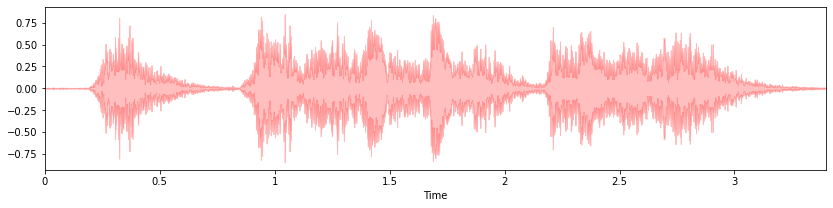

Mel-Spectogram mean = 5.47025
Mel-Spectogram minimum = 53.24934
Mel-Spectogram maximum = 53.24934
Mel-Spectogram standard deviation = 53.24934
Mel-Spectogram variance = 53.24934


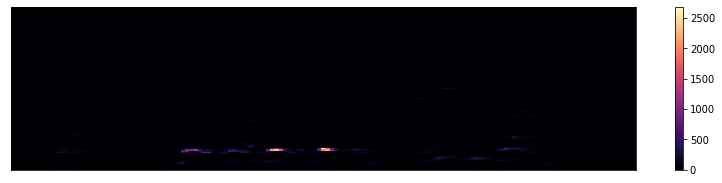

Chromogram mean = 0.40250
Chromogram minimum = 0.31185
Chromogram maximum = 0.31185
Chromogram standard deviation = 0.31185
Chromogram variance = 0.31185


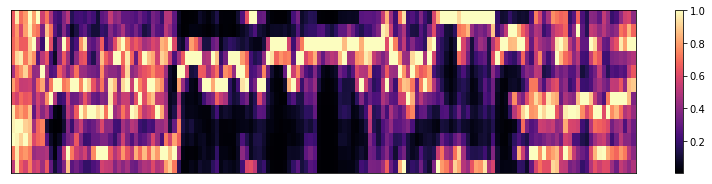

Spectral Centroids mean = 0.30606
Spectral Rolloff mean = 0.50089


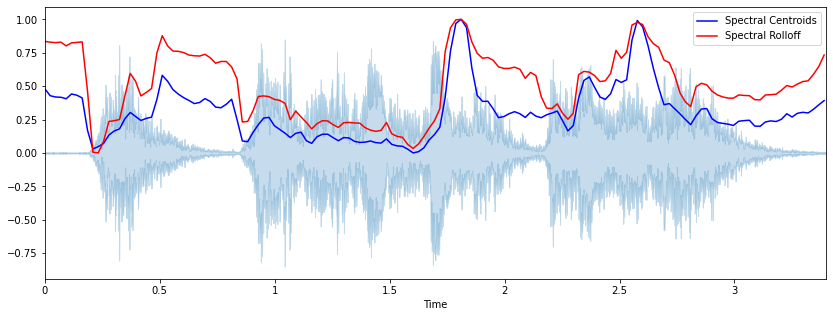

RMSE mean = 0.37606


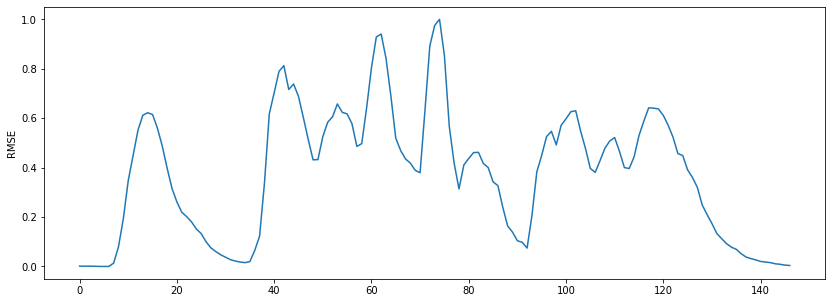

Zero Crossing Rate mean = 0.27523


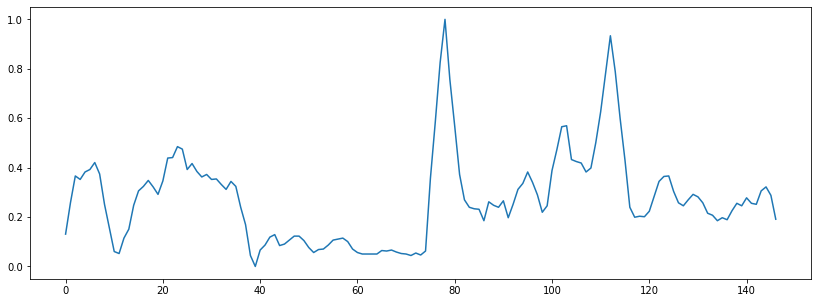

In [16]:
for index, row in df.iterrows():
    audio_analsys(row)
    break